## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
#from model3D import *
from model3D_small import *
import math
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.np_utils  import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2023-04-17 11:38:37.327136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Data Description

In [2]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [3]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
print(meta_data.head())

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


In [4]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

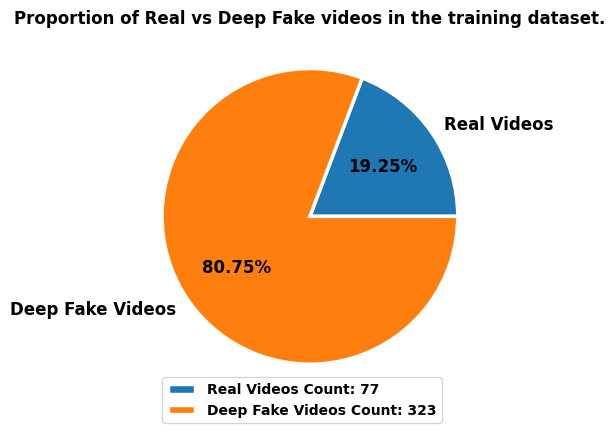

In [5]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

## Frames

In [6]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array_colors = []
    for idx, path in enumerate(paths): 
        if idx == video_amount:
            break
        vc = cv2.VideoCapture(path)
        frames_to_skip = (int(vc.get(cv2.CAP_PROP_FRAME_COUNT))-5)/frames_each_video
        frames_to_skip = math.floor(frames_to_skip)
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                frame = cv2.resize(frame, (1080, 720))
                video.append((cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255))
            else:
                vc.release()
                break
        #if len(video) < 150:        # for å catch vid me for lite frames
        #    print(len(video), idx)
        #    video.append(video[-1])
        #    print(len(video))
        video_array_colors.append(np.array(video))
    return np.array(video_array_colors)


In [7]:
training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []
for path in paths_col:
    complete_paths.append(train_videoes+"/"+path)
complete_paths.sort()
vid_arr_col = get_frames_v1(paths=complete_paths, frames_each_video=10, video_amount=100)

In [8]:
print(vid_arr_col.shape)
#vid_arr_gray = np.expand_dims(vid_arr_gray, axis=-1)
#print(vid_arr_gray.shape)
print(vid_arr_col[8].shape)

(100, 10, 720, 1080, 3)
(10, 720, 1080, 3)


In [9]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)
y = to_categorical(y, num_classes=None).astype(int)
y[:10]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [10]:
print(f"Amount of Videos: {len(vid_arr_col)}")
# print(f"Frames for videos: {[len(vid_arr_col[i]) for i in range(len(vid_arr_col))]}")
print(f"Frames for videos: {[len(vid_arr_col[i]) for i in range(10)]}")

Amount of Videos: 100
Frames for videos: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


### Plot frames

In [19]:
from keras.applications.imagenet_utils import preprocess_input
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

2023-04-17 11:59:20.887356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def extract_features(video_array):
    features = []
    face_regions = []

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    noFaceFound = 0
    for video in tqdm(video_array):
        video_features = []
        video_face_regions = []

        for frame in video:
            gray_frame = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            if len(faces) > 0:
                x, y, w, h = max(faces, key=lambda face: face[2] * face[3])
                face_img = frame[y:y+h, x:x+w]
                face_img = cv2.resize(face_img, (224, 224))

                face_img = preprocess_input(face_img * 255)
                face_img = np.expand_dims(face_img, axis=0)
                feature = model.predict(face_img)
                video_features.append(feature.squeeze())

                video_face_regions.append(frame[y:y+h, x:x+w])

            else:
                continue

        if video_features:
            features.append(np.mean(video_features, axis=0))
            face_regions.append(video_face_regions[0])
        else:
            print("No faces detected in any frame of this video.")
            noFaceFound += 1
            if features:  # Check if the features list is not empty
                features.append(np.zeros_like(features[-1]))  # Add zeros if no faces are detected
                face_regions.append(np.zeros((224, 224, 3)))  # Add a placeholder image with the same size as the face images

    return np.array(features), face_regions
video_features, face_regions = extract_features(vid_arr_col)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 133ms/step


  1%|          | 1/100 [00:08<13:30,  8.18s/it]

1/1 [==============================] - 0s 145ms/step


  2%|▏         | 2/100 [00:12<09:30,  5.82s/it]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 3/100 [00:16<08:14,  5.10s/it]

1/1 [==============================] - 0s 168ms/step


  4%|▍         | 4/100 [00:20<07:32,  4.71s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 5/100 [00:25<07:39,  4.84s/it]

1/1 [==============================] - 0s 136ms/step


  6%|▌         | 6/100 [00:31<08:17,  5.29s/it]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 7/100 [00:37<08:15,  5.33s/it]

1/1 [==============================] - 0s 158ms/step


  8%|▊         | 8/100 [00:41<07:29,  4.89s/it]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 9/100 [00:46<07:24,  4.88s/it]

1/1 [==============================] - 0s 116ms/step


 10%|█         | 10/100 [00:49<06:44,  4.49s/it]

1/1 [==============================] - 0s 133ms/step


 11%|█         | 11/100 [00:53<06:24,  4.33s/it]

1/1 [==============================] - 0s 166ms/step


 12%|█▏        | 12/100 [01:01<08:03,  5.49s/it]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 13/100 [01:06<07:33,  5.21s/it]

1/1 [==============================] - 0s 246ms/step


 14%|█▍        | 14/100 [01:14<08:41,  6.07s/it]

1/1 [==============================] - 0s 154ms/step


 15%|█▌        | 15/100 [01:20<08:26,  5.96s/it]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 16/100 [01:24<07:45,  5.54s/it]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 18/100 [01:32<06:17,  4.61s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 19/100 [01:37<06:17,  4.66s/it]

1/1 [==============================] - 0s 128ms/step


 20%|██        | 20/100 [01:41<05:56,  4.46s/it]

1/1 [==============================] - 0s 246ms/step


 21%|██        | 21/100 [01:47<06:20,  4.81s/it]

1/1 [==============================] - 0s 150ms/step


 22%|██▏       | 22/100 [01:54<07:20,  5.65s/it]

1/1 [==============================] - 0s 148ms/step


 23%|██▎       | 23/100 [01:59<07:02,  5.48s/it]

1/1 [==============================] - 0s 131ms/step


 24%|██▍       | 24/100 [02:03<06:23,  5.04s/it]

1/1 [==============================] - 0s 133ms/step


 25%|██▌       | 25/100 [02:11<07:10,  5.75s/it]

1/1 [==============================] - 0s 141ms/step


 26%|██▌       | 26/100 [02:14<06:05,  4.93s/it]

1/1 [==============================] - 0s 202ms/step


 27%|██▋       | 27/100 [02:18<05:46,  4.75s/it]

1/1 [==============================] - 0s 331ms/step


 28%|██▊       | 28/100 [02:25<06:37,  5.53s/it]

1/1 [==============================] - 0s 143ms/step


 29%|██▉       | 29/100 [02:29<05:45,  4.86s/it]

1/1 [==============================] - 0s 132ms/step


 30%|███       | 30/100 [02:34<05:49,  4.99s/it]

1/1 [==============================] - 0s 285ms/step


 31%|███       | 31/100 [02:40<05:56,  5.17s/it]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 32/100 [02:45<05:58,  5.27s/it]

1/1 [==============================] - 0s 142ms/step


 33%|███▎      | 33/100 [02:49<05:32,  4.96s/it]

1/1 [==============================] - 0s 140ms/step


 34%|███▍      | 34/100 [02:53<05:00,  4.55s/it]

1/1 [==============================] - 0s 145ms/step


 35%|███▌      | 35/100 [02:57<04:48,  4.43s/it]

1/1 [==============================] - 0s 137ms/step


 36%|███▌      | 36/100 [03:02<04:48,  4.50s/it]

1/1 [==============================] - 0s 141ms/step


 37%|███▋      | 37/100 [03:05<04:26,  4.23s/it]

1/1 [==============================] - 0s 206ms/step


 38%|███▊      | 38/100 [03:11<04:58,  4.82s/it]

1/1 [==============================] - 0s 158ms/step


 39%|███▉      | 39/100 [03:16<04:42,  4.63s/it]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 40/100 [03:22<05:00,  5.01s/it]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 42/100 [03:29<04:04,  4.22s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 184ms/step


 43%|████▎     | 43/100 [03:36<04:52,  5.12s/it]

1/1 [==============================] - 0s 310ms/step


 44%|████▍     | 44/100 [03:41<04:48,  5.16s/it]

1/1 [==============================] - 0s 131ms/step


 45%|████▌     | 45/100 [03:52<06:05,  6.64s/it]

1/1 [==============================] - 0s 156ms/step


 46%|████▌     | 46/100 [03:57<05:35,  6.22s/it]

1/1 [==============================] - 0s 249ms/step


 47%|████▋     | 47/100 [04:02<05:05,  5.77s/it]

1/1 [==============================] - 0s 454ms/step


 48%|████▊     | 48/100 [04:09<05:24,  6.24s/it]

1/1 [==============================] - 0s 127ms/step


 49%|████▉     | 49/100 [04:14<04:58,  5.86s/it]

1/1 [==============================] - 0s 133ms/step


 50%|█████     | 50/100 [04:18<04:21,  5.24s/it]

1/1 [==============================] - 0s 135ms/step


 51%|█████     | 51/100 [04:21<03:47,  4.65s/it]

1/1 [==============================] - 0s 138ms/step


 52%|█████▏    | 52/100 [04:25<03:31,  4.40s/it]

1/1 [==============================] - 0s 135ms/step


 53%|█████▎    | 53/100 [04:28<03:17,  4.20s/it]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 54/100 [04:31<02:45,  3.60s/it]

1/1 [==============================] - 0s 197ms/step


 56%|█████▌    | 56/100 [04:38<02:29,  3.40s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 135ms/step


 57%|█████▋    | 57/100 [04:45<03:18,  4.61s/it]

1/1 [==============================] - 0s 138ms/step


 59%|█████▉    | 59/100 [04:51<02:32,  3.71s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 144ms/step


 60%|██████    | 60/100 [04:58<03:00,  4.51s/it]

1/1 [==============================] - 0s 155ms/step


 61%|██████    | 61/100 [05:02<02:55,  4.50s/it]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 62/100 [05:05<02:34,  4.06s/it]

1/1 [==============================] - 0s 139ms/step


 63%|██████▎   | 63/100 [05:09<02:24,  3.92s/it]

1/1 [==============================] - 0s 140ms/step


 64%|██████▍   | 64/100 [05:16<02:51,  4.76s/it]

1/1 [==============================] - 0s 139ms/step


 65%|██████▌   | 65/100 [05:20<02:42,  4.64s/it]

1/1 [==============================] - 0s 217ms/step


 66%|██████▌   | 66/100 [05:28<03:08,  5.54s/it]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 67/100 [05:33<03:00,  5.48s/it]

1/1 [==============================] - 0s 145ms/step


 68%|██████▊   | 68/100 [05:43<03:38,  6.82s/it]

1/1 [==============================] - 0s 147ms/step


 69%|██████▉   | 69/100 [05:51<03:40,  7.10s/it]

1/1 [==============================] - 0s 126ms/step


 70%|███████   | 70/100 [05:56<03:21,  6.72s/it]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 72/100 [06:00<01:55,  4.11s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 137ms/step


 73%|███████▎  | 73/100 [06:04<01:53,  4.19s/it]

1/1 [==============================] - 0s 134ms/step


 74%|███████▍  | 74/100 [06:09<01:53,  4.35s/it]

1/1 [==============================] - 0s 143ms/step


 75%|███████▌  | 75/100 [06:13<01:47,  4.31s/it]

1/1 [==============================] - 0s 184ms/step


 76%|███████▌  | 76/100 [06:18<01:45,  4.38s/it]

1/1 [==============================] - 0s 258ms/step


 77%|███████▋  | 77/100 [06:23<01:50,  4.80s/it]

1/1 [==============================] - 0s 193ms/step


 78%|███████▊  | 78/100 [06:29<01:49,  4.97s/it]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 80/100 [06:38<01:32,  4.62s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 153ms/step


 81%|████████  | 81/100 [06:41<01:17,  4.07s/it]

1/1 [==============================] - 0s 197ms/step


 82%|████████▏ | 82/100 [06:51<01:46,  5.91s/it]

1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 84/100 [07:00<01:18,  4.88s/it]

No faces detected in any frame of this video.
1/1 [==============================] - 0s 160ms/step


 85%|████████▌ | 85/100 [07:04<01:10,  4.71s/it]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 86/100 [07:10<01:09,  5.00s/it]

1/1 [==============================] - 0s 380ms/step


 87%|████████▋ | 87/100 [07:20<01:23,  6.41s/it]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 88/100 [07:26<01:18,  6.52s/it]

1/1 [==============================] - 0s 133ms/step


 89%|████████▉ | 89/100 [07:30<01:00,  5.48s/it]

1/1 [==============================] - 0s 291ms/step


 90%|█████████ | 90/100 [07:34<00:51,  5.19s/it]

1/1 [==============================] - 0s 139ms/step


 91%|█████████ | 91/100 [07:36<00:37,  4.15s/it]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 92/100 [07:41<00:35,  4.50s/it]

1/1 [==============================] - 0s 144ms/step


 93%|█████████▎| 93/100 [07:45<00:31,  4.46s/it]

1/1 [==============================] - 0s 149ms/step


 94%|█████████▍| 94/100 [07:50<00:26,  4.49s/it]

1/1 [==============================] - 0s 163ms/step


 95%|█████████▌| 95/100 [07:55<00:23,  4.71s/it]

1/1 [==============================] - 0s 172ms/step


 96%|█████████▌| 96/100 [08:01<00:20,  5.07s/it]

1/1 [==============================] - 0s 287ms/step


 97%|█████████▋| 97/100 [08:10<00:18,  6.30s/it]

1/1 [==============================] - 0s 148ms/step


 98%|█████████▊| 98/100 [08:16<00:12,  6.05s/it]

1/1 [==============================] - 0s 270ms/step


 99%|█████████▉| 99/100 [08:20<00:05,  5.54s/it]

1/1 [==============================] - 0s 131ms/step


100%|██████████| 100/100 [08:26<00:00,  5.06s/it]


In [14]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [21]:
def plot_tsne_with_images(tsne_results, face_regions, figsize=(4, 4), thumbnail_size=(64, 36)):
    fig, ax = plt.subplots(figsize=figsize)

    for i in range(tsne_results.shape[0]):
        x, y = tsne_results[i, :]

        img = face_regions[i]
        img = cv2.resize(img, thumbnail_size)

        img_box = offsetbox.OffsetImage(img, zoom=1, cmap='gray')
        img_annotation = offsetbox.AnnotationBbox(img_box, (x, y), xycoords='data', frameon=False)

        ax.add_artist(img_annotation)

    ax.set_xlim(tsne_results[:, 0].min() - 10, tsne_results[:, 0].max() + 10)
    ax.set_ylim(tsne_results[:, 1].min() - 10, tsne_results[:, 1].max() + 10)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title('t-SNE Plot of Video Features with Face Thumbnails')
    plt.show()


In [22]:
tsne = TSNE(n_components=2, random_state=42,perplexity=1)
tsne_results = tsne.fit_transform(video_features)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [17]:
from matplotlib import offsetbox
from tensorflow.keras.applications.resnet50 import ResNet50

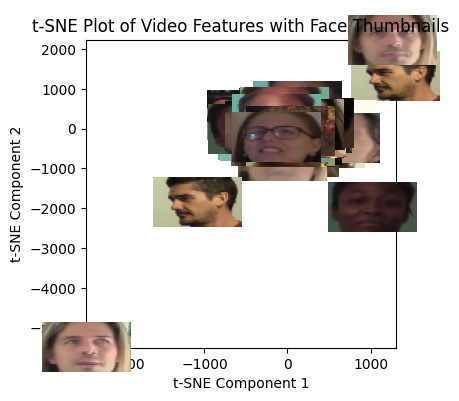

In [23]:
plot_tsne_with_images(tsne_results, face_regions)

In [ ]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()


In [ ]:
def plot_faces(faces: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    num_faces = min(len(faces), width * height)
    for i in range(num_faces):
        plt.subplot(width, height, i + 1)
        plt.imshow(faces[i])
        plt.axis('off')
    plt.show()
    

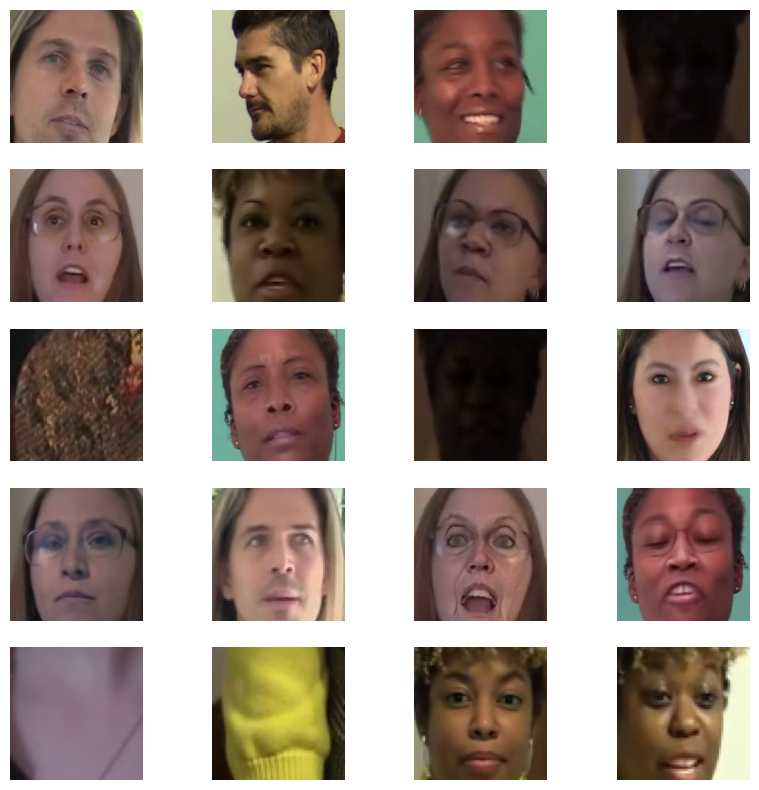

In [ ]:
plot_faces(face_regions, figsize=(10, 10), width=5, height=4)

TypeError: Invalid shape () for image data

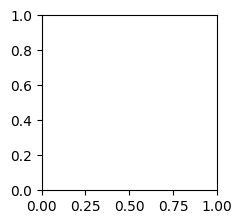

In [ ]:
plot_video(video_features[0], (30,5), 2, 5)

## tSNE

In [ ]:
from sklearn.manifold import TSNE

frames_list = vid_arr_col[0]
frames_array = np.array([frame.flatten() for frame in frames_list])

# Instantiate t-SNE object with desired parameters
tsne = TSNE(n_components=2, perplexity=5, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


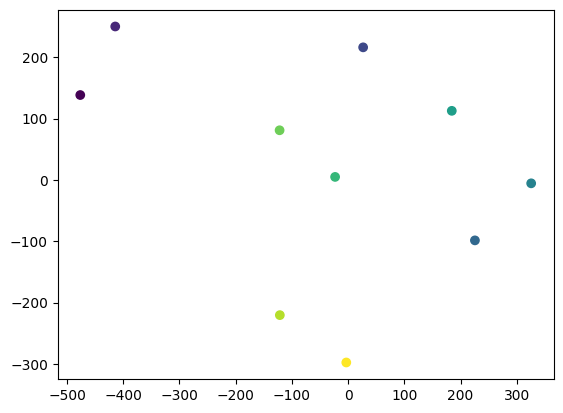

In [ ]:
# Assuming labels is a list of labels corresponding to each frame
plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=range(0,10))
plt.show()

In [ ]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])

In [ ]:
first_frame_formatted = format_frames(vid_arr_col)
first_frame_formatted.shape

(1, 30, 53, 3)

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [ ]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=np.argmax(y, axis=1))
class_weights = dict(zip(np.unique(y), weight_class))
class_weights

{0: 2.5974025974025974, 1: 0.6191950464396285}

In [ ]:
def build_3D_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=16, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=8, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(2 ,activation="softmax"))
    return model


In [ ]:
def test_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=32, kernel_size=(2,2,2),input_shape=input_data.shape[1:],
                activation='relu',
                padding='same', data_format='channels_last'))
    model.add(layers.BatchNormalization())
    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))

    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
    model.add(layers.Flatten())

    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32,activation='elu'))

    model.add(layers.Dense(2,activation='sigmoid'))
    return model

In [ ]:
test_m = test_model(vid_arr_col)
test_m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           (None, 10, 30, 53, 32)    800       
                                                                 
 batch_normalization (BatchN  (None, 10, 30, 53, 32)   128       
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 30, 53, 16)    12352     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 30, 53, 16)   64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 10, 30, 53, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 15, 26, 16)   

In [ ]:
loss = "binary_crossentropy"
optimizer = "adam"
metrics=["accuracy"]
test_m.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_test = test_m.fit(vid_arr_col, 
                          y[:vid_arr_col.shape[0]],
                          epochs=10, 
                          batch_size=10, 
                          verbose=1, 
                          class_weight=class_weights)

Epoch 1/10
7/7 [==============================] - 16s 2s/step - loss: 0.9956 - accuracy: 0.5714
Epoch 2/10
7/7 [==============================] - 11s 2s/step - loss: 0.7674 - accuracy: 0.7143
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.4592 - accuracy: 0.7857
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.3966 - accuracy: 0.8286
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.2998 - accuracy: 0.8857
Epoch 6/10
7/7 [==============================] - 8s 1s/step - loss: 0.2335 - accuracy: 0.9143
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.2430 - accuracy: 0.9000
Epoch 8/10
7/7 [==============================] - 7s 1s/step - loss: 0.1966 - accuracy: 0.9143
Epoch 9/10
7/7 [==============================] - 8s 1s/step - loss: 0.1793 - accuracy: 0.9429
Epoch 10/10
7/7 [==============================] - 8s 1s/step - loss: 0.1637 - accuracy: 0.9429


In [ ]:
pred_y = test_m.predict(vid_arr_col)

3/3 [==============================] - 3s 386ms/step


In [ ]:
pred_y[:5]

array([[0.560338  , 0.82402724],
       [0.5523356 , 0.82179487],
       [0.65457153, 0.7903483 ],
       [0.56366897, 0.8121844 ],
       [0.5719051 , 0.8211926 ]], dtype=float32)

In [ ]:
actual_y = np.argmax(y[:vid_arr_col.shape[0]], axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.843     1.000     0.915        59

    accuracy                          0.843        70
   macro avg      0.421     0.500     0.457        70
weighted avg      0.710     0.843     0.771        70



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [ ]:
pred_y.sum()

70

In [ ]:
actual_y

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1])

In [ ]:
cfm = confusion_matrix(actual_y, pred_y)

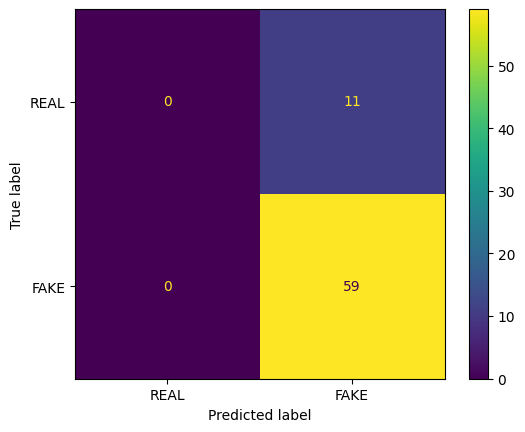

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()

In [ ]:
model_3D_col = build_3D_model(vid_arr_col)
model_3D_col.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 10, 30, 53, 64)    5248      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 15, 27, 64)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 15, 27, 32)     55328     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 8, 14, 32)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 8, 14, 16)      13840     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 2, 4, 7, 16)     

In [ ]:
loss = "binary_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate = 0.1)
metrics=["accuracy"]
model_3D_col.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model_3D_col.fit(vid_arr_col, 
                           y[:vid_arr_col.shape[0]],
                           epochs=10, 
                           batch_size=10, 
                           verbose=2)

Epoch 1/10
7/7 - 12s - loss: 15583.8818 - accuracy: 0.6143 - 12s/epoch - 2s/step
Epoch 2/10
7/7 - 10s - loss: 11.5522 - accuracy: 0.6714 - 10s/epoch - 1s/step
Epoch 3/10
7/7 - 10s - loss: 17.0737 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 4/10
7/7 - 10s - loss: 0.4294 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 5/10
7/7 - 10s - loss: 0.4546 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 6/10
7/7 - 10s - loss: 0.4378 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 7/10
7/7 - 10s - loss: 0.4416 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 8/10
7/7 - 10s - loss: 0.4405 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 9/10
7/7 - 10s - loss: 0.4358 - accuracy: 0.8429 - 10s/epoch - 1s/step
Epoch 10/10
7/7 - 10s - loss: 0.4390 - accuracy: 0.8429 - 10s/epoch - 1s/step


In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]
model_3D_col.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Plotting performance

In [ ]:
print(history_test.params)
print(history_test.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 7}
dict_keys(['loss', 'accuracy'])


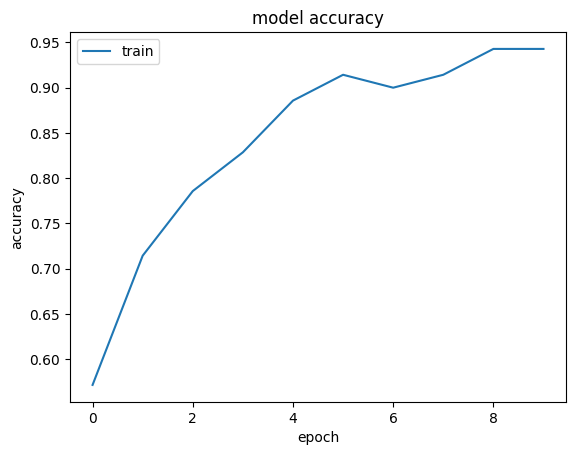

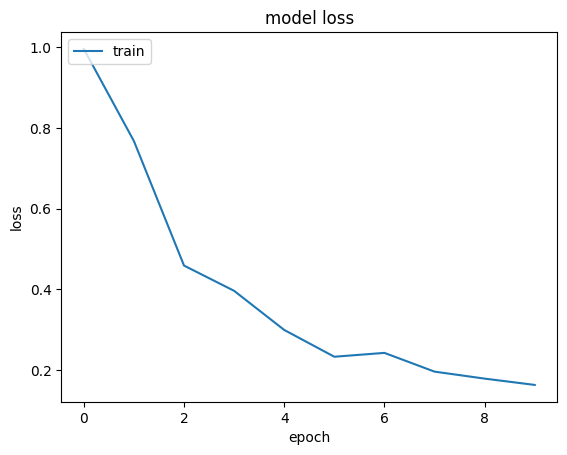

In [ ]:
# summarize history for accuracy
plt.plot(history_test.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_test.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()